In [1]:
!pip install import-ipynb
import import_ipynb
import HeatCurrentFunctions as QH

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc


Jm_h = QH.sm1 + QH.sm2
Jp_h = QH.sp1 + QH.sp2
Jm_c = QH.sm1 - QH.sm2
Jp_c = QH.sp1 - QH.sp2

w0 = 1          # LC resonator frequency (sets the unit scale)
Qf = 7.1798      # Resonator quality factor

# Bath coupling strengths
gamma_h   = 0.0075   # Hot bath
gamma_c   = 0.0075   # Cold bath
gamma_local = 0.001 #0.001   # Parasitic relaxation
gamma_deph  = 0  # Pure dephasing (σ_z)

# Temperatures  (ℏ = k_B = 1)
T_local = 0.186    # Parasitic bath, 50 mK
T_h     = 1.2087    # Hot bath, 350 mK
T_c     = 0.186   # Cold bath, 50 mK
N= 101

# Diagnostic: effective temperature of the composite resonator bath
Ts = QH.T_star(T_c, gamma_c, T_h, gamma_h, w0)
print("T* =", Ts)

T* = 0.7877024107695239


In [4]:
# -------------------------------------------------------------------
# Frequency grid and heat-current maps
# -------------------------------------------------------------------
w_vals = np.linspace(0.5, 1.5, N)
W1, W2 = np.meshgrid(w_vals, w_vals)

Q_ind   = np.zeros_like(W1)   # independent current
Q_coll_sup  = np.zeros_like(W1)   # collective current
Q_coll_sub = np.zeros_like(W1)  
Ratio_sup   = np.zeros_like(W1)   # enhancement factor
Ratio_sub   = np.zeros_like(W1)
Lambda_sup  = np.zeros_like(W1)   # minimum eigenvalue (positivity check)
Lambda_sub =  np.zeros_like(W1)
Rho_ind = np.zeros_like(W1)
Rho_coll_sup_2 = np.zeros((N, N, 4,4))
Rho_coll_sub_2 = np.zeros((N, N, 4,4))
Rho_coll_sup = np.zeros_like(W1)
Rho_coll_sub = np.zeros_like(W1)

for i, w1 in enumerate(w_vals):
    for j, w2 in enumerate(w_vals):

        # Independent-bath steady state and current
        rho_ind = QH.rho_ss_termic_indepentend(
            w1, w2,
            gamma_local, T_local, gamma_deph,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf
        )
        Rho_ind[j, i] = np.real(rho_ind[1][1])
        Q_ind[j, i] = QH.Current_ind(w1, w2, rho_ind, T_h, gamma_h, w0, Qf)

        # Collective-bath steady state and current
        rho_coll_sup = QH.rho_ss_termic_collective_sup(
            w1, w2,
            gamma_local, T_local, gamma_deph,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf
        )
        Rho_coll_sup_2[j, i, :, :] = np.real(rho_coll_sup.full())
        Rho_coll_sup[j, i] = np.real(rho_coll_sup[1][2])
        Q_coll_sup[j, i] = QH.Current_coll(w1, w2, rho_coll_sup, T_h, gamma_h, w0, Qf, Jm_h, Jp_h)

        # Diagnostics
        Lambda_sup[j, i] = np.min(np.linalg.eigvalsh(rho_coll_sup.full()))
        Ratio_sup[j, i]  = Q_coll_sup[j, i] / Q_ind[j, i]
        
        
        # Collective-bath steady state and current
        rho_coll_sub = QH.rho_ss_termic_collective_sub(
            w1, w2,
            gamma_local, T_local, gamma_deph,
            T_h, gamma_h, T_c, gamma_c,
            w0, Qf
        )
        Rho_coll_sub[j, i] = np.real(rho_coll_sub[1][2])
        Rho_coll_sub_2[j, i, :, :] = np.real(rho_coll_sub.full())
        Q_coll_sub[j, i] = QH.Current_coll(w1, w2, rho_coll_sub, T_h, gamma_h, w0, Qf, Jm_h, Jp_h)

        # Diagnostics
        Lambda_sub[j, i] = np.min(np.linalg.eigvalsh(rho_coll_sub.full()))
        Ratio_sub[j, i]  = Q_coll_sub[j, i] / Q_ind[j, i]

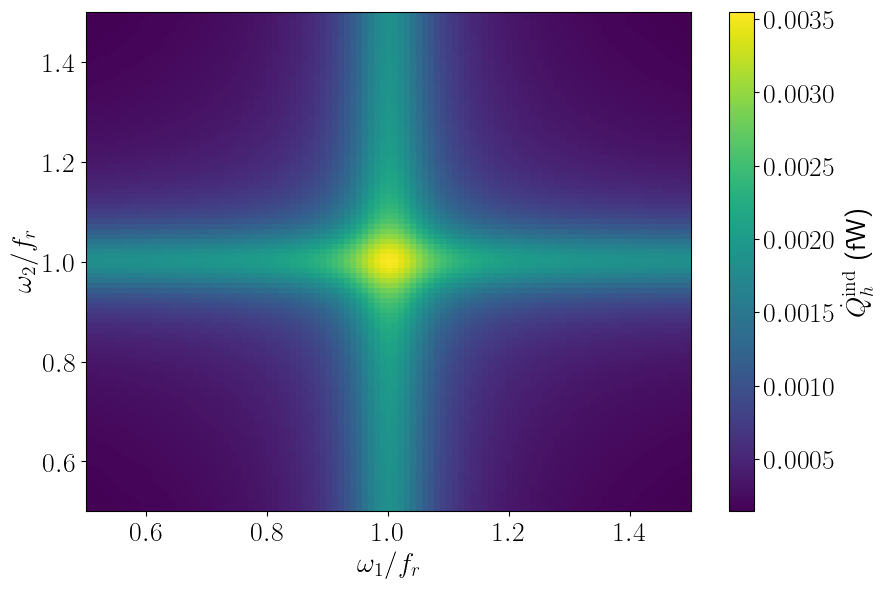

In [5]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    (Q_ind), 
    extent=(w_vals.min(), w_vals.max(), w_vals.min(), w_vals.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$\omega_1/f_r$', fontsize=20)
plt.ylabel(r'$\omega_2/f_r$', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q^{\rm ind}_h$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

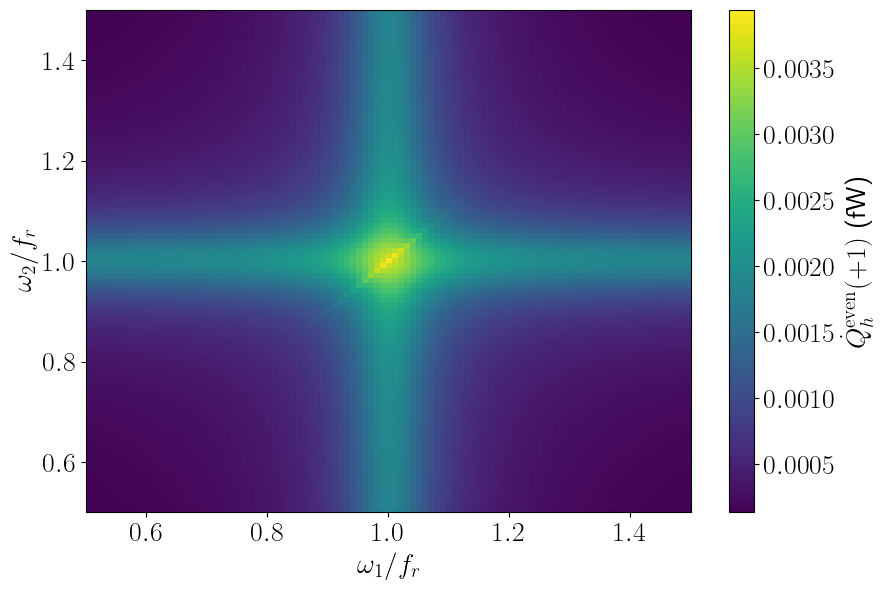

In [6]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    (Q_coll_sup),  # negative heat current for display
    extent=(w_vals.min(), w_vals.max(), w_vals.min(), w_vals.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$\omega_1/f_r$', fontsize=20)
plt.ylabel(r'$\omega_2/f_r$', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q_h^{\rm even} (+1)$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

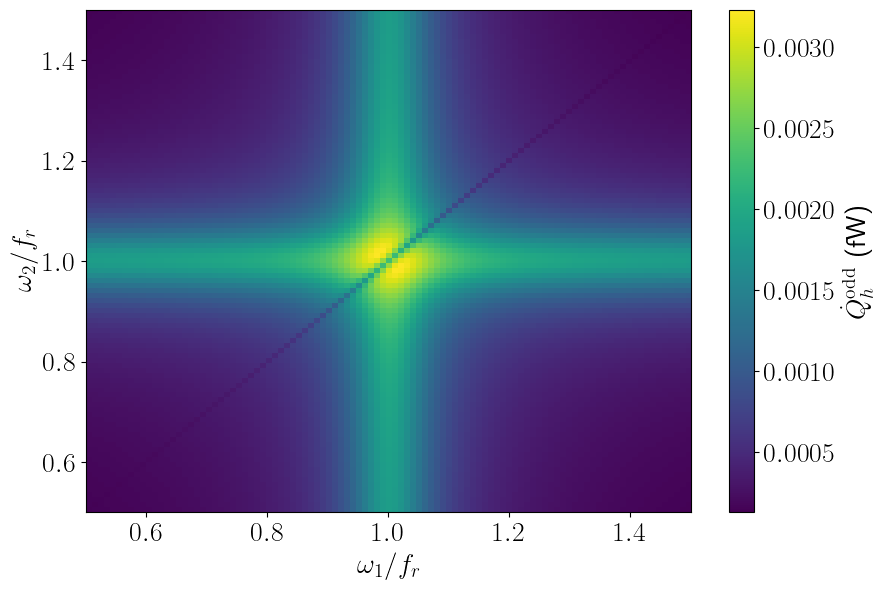

In [7]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    (Q_coll_sub),  # negative heat current for display
    extent=(w_vals.min(), w_vals.max(), w_vals.min(), w_vals.max()),
    aspect='auto',
    origin='lower'
)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(r'$\omega_1/f_r$', fontsize=20)
plt.ylabel(r'$\omega_2/f_r$', fontsize=20)

cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\dot Q_h^{\rm odd}$ (fW)', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()

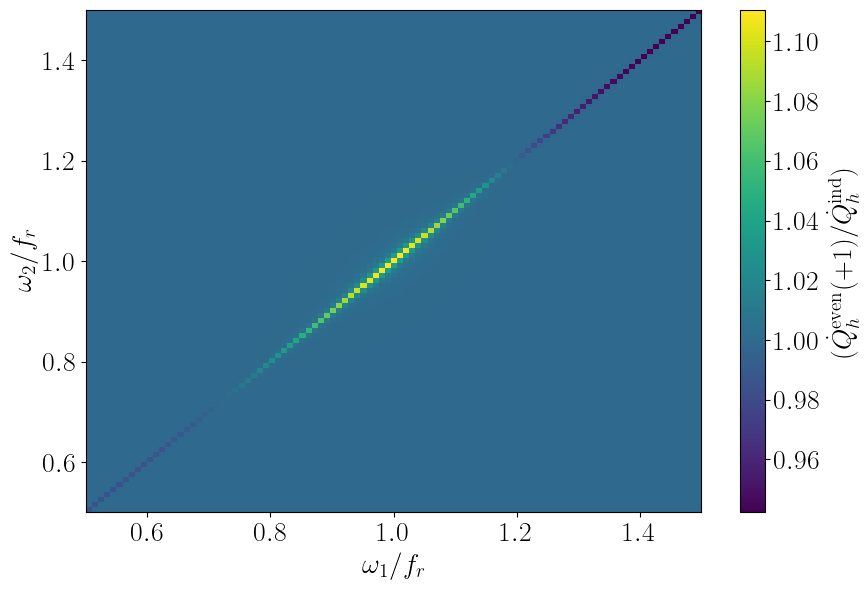

In [8]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Ratio_sup,  
    extent=(w_vals.min(), w_vals.max(), w_vals.min(), w_vals.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$\omega_1/f_r$', fontsize=20)
plt.ylabel(r'$\omega_2/f_r$', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$(\dot Q_h^{\rm even} (+1)/\dot Q_h^{\rm ind})$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

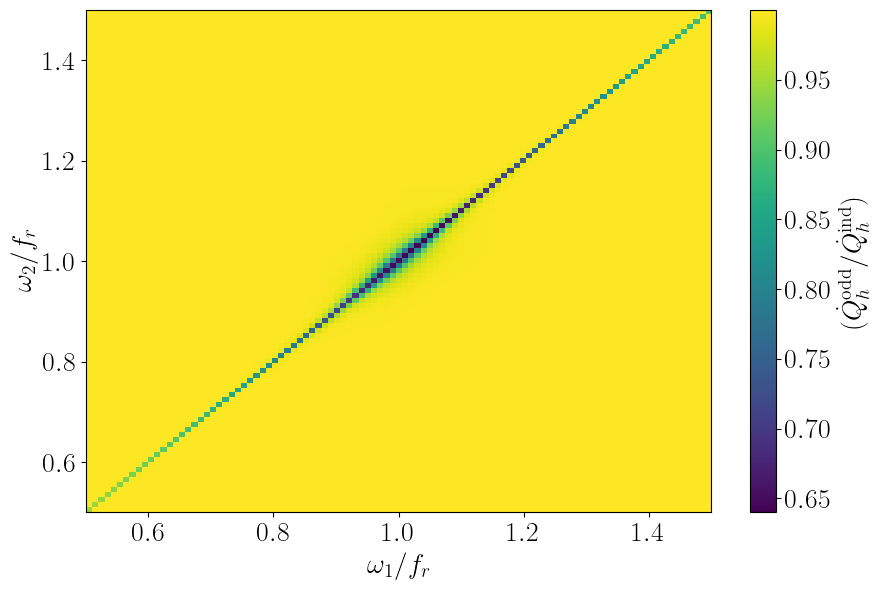

In [9]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Ratio_sub,  
    extent=(w_vals.min(), w_vals.max(), w_vals.min(), w_vals.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$\omega_1/f_r$', fontsize=20)
plt.ylabel(r'$\omega_2/f_r$', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$(\dot Q_h^{\rm odd}/\dot Q_h^{\rm ind})$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

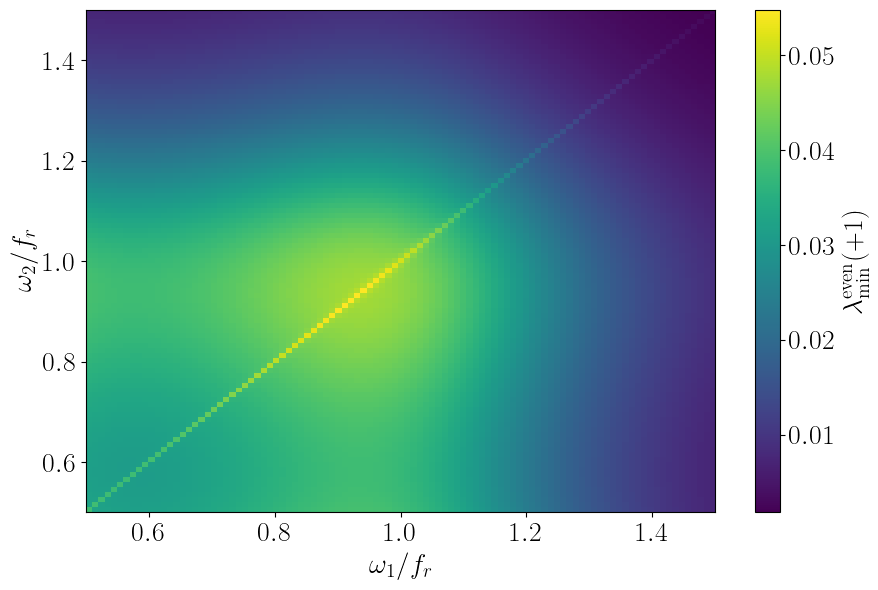

In [10]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Lambda_sup,  # negative heat current for display
    extent=(w_vals.min(), w_vals.max(), w_vals.min(), w_vals.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$\omega_1/f_r$', fontsize=20)
plt.ylabel(r'$\omega_2/f_r$', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\lambda_{\rm min}^{\rm even} (+1)$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

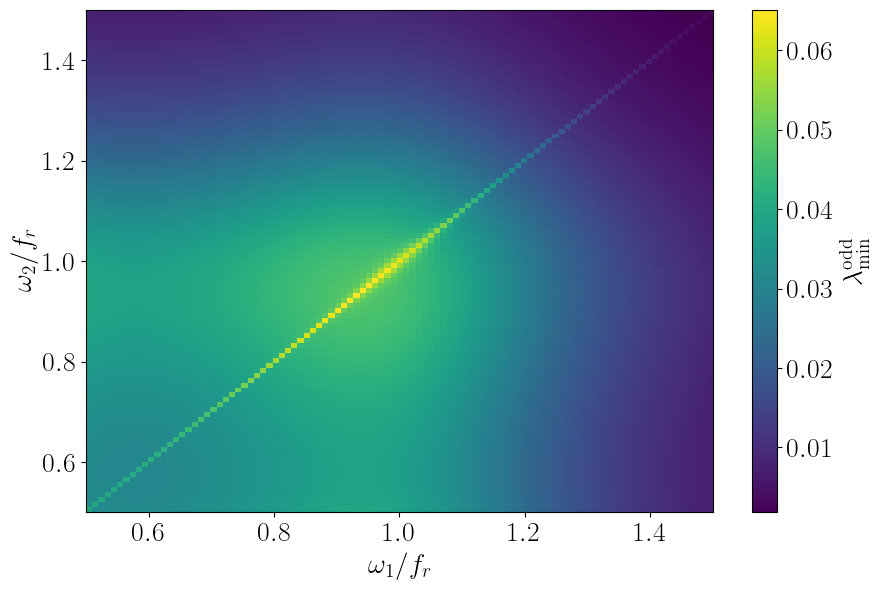

In [11]:
plt.figure(figsize=(9, 6))
rc('text',usetex=True)

cp = plt.imshow(
    Lambda_sub,  # negative heat current for display
    extent=(w_vals.min(), w_vals.max(), w_vals.min(), w_vals.max()),
    aspect='auto',
    origin='lower'
)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.xlabel(r'$\omega_1/f_r$', fontsize=20)
plt.ylabel(r'$\omega_2/f_r$', fontsize=20)



# Catturo la colorbar in 'cbar'
cbar = plt.colorbar(cp)
# Imposto la label con fontsize
cbar.set_label(r'$\lambda_{\rm min}^{\rm odd}$', fontsize=20)
# Regolo la dimensione dei tick
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

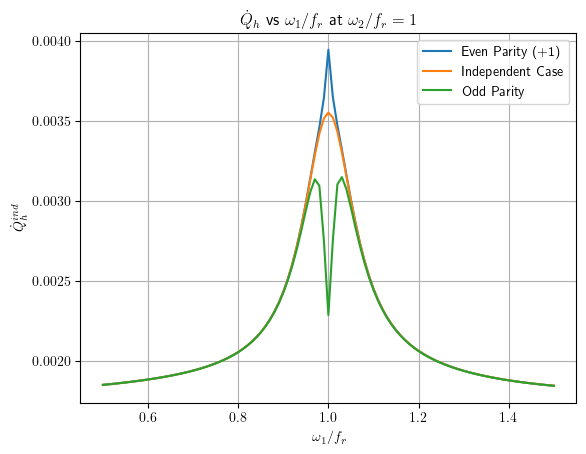

In [12]:
sup = (Q_coll_sup[:, 50]) # in fW
ind = (Q_ind[:, 50])
sub = (Q_coll_sub[:, 50])
#i1_axis = w_vals  # in mA

# Plot it

plt.plot(w_vals, sup, label = 'Even Parity (+1)')
plt.plot(w_vals, ind, label = 'Independent Case')
plt.plot(w_vals, sub, label = 'Odd Parity')
plt.xlabel(r'$\omega_1/f_r$')
plt.ylabel(r'$\dot{Q}_h^{ind}$')
plt.title(r'$\dot{Q}_h$ vs $\omega_1/f_r$ at $\omega_2/f_r = 1$')
plt.legend()
plt.grid(True)
plt.show()
#np.max(horizontal_cut)

In [13]:
N2 = 1000
w_r = 4e9
w0 = 1
w1 = 1 #4e9/w_r          # LC resonator frequency (sets the unit scale)
#w2 = 2e9/w_r
#w0_2 = 2e9
Qf_2 = 7.1798      # Resonator quality factor

# Bath coupling strengths
gamma_h_2   = 10*0.0075 #0.5e9/w_r    # Hot bath
gamma_c_2   = 10*0.0075 #0.5e9/w_r    # Cold bath
#gamma_h_3 = 0.000138 #gamma_h_2/(1 + Qf_2**2 * (w2/w0 - w0/w2)**2)
#gamma_c_3 = 0.000138

# Temperatures  (ℏ = k_B = 1)
#T_local = 0.186    # Parasitic bath
T_h_2     = 1.2087 #8e9/w_r  # Hot bath
T_c_2     = 0.186  #1e9/w_r   # Cold bath

gamma_deph_2 = 0
T_par = np.linspace(0.186, 1.673, N2)
Q_ind_2   = np.zeros(N2)   # independent current
Q_coll_sup_2  = np.zeros(N2)  # collective current
Q_coll_sub_2  = np.zeros(N2)  # collective current
Ratio_sup_2   = np.zeros(N2)   # enhancement factor
Ratio_sub_2   = np.zeros(N2) 
Lambda_sup_2  = np.zeros(N2) 
Lambda_sub_2  = np.zeros(N2)   # minimum eigenvalue (positivity check)
#Rho_ind_2 = np.zeros(N2)
#Rho_coll_2 = np.zeros(N2)
gamma_p = 0.001 #0.01e9/w_r

for k, T_p in enumerate(T_par):
    

    # Independent-bath steady state and current
    rho_ind = QH.rho_ss_termic_indepentend(
        w1, w1,
        gamma_p, T_p, gamma_deph_2,
        T_h_2, gamma_h_2, T_c_2, gamma_c_2,
        w0, Qf_2
    )
    #Rho_ind_2[k] = np.real(rho_ind[1][1])
    Q_ind_2[k] = QH.Current_ind(w1, w1, rho_ind, T_h_2, gamma_h_2, w0, Qf_2)

    # Collective-bath steady state and current
    rho_coll_sup = QH.rho_ss_termic_collective_sup(
        w1, w1,
        gamma_p, T_p, gamma_deph_2,
        T_h_2, gamma_h_2, T_c_2, gamma_c_2,
        w0, Qf_2
    )
    #Rho_coll_2[k] = np.real(rho_coll[1][2])
    Q_coll_sup_2[k] = QH.Current_coll(w1, w1, rho_coll_sup, T_h_2, gamma_h_2, w0, Qf_2, Jm_h, Jp_h)

    # Diagnostics
    Lambda_sup_2[k] = np.min(np.linalg.eigvalsh(rho_coll_sup.full()))
    Ratio_sup_2[k]  = Q_coll_sup_2[k] / Q_ind_2[k]
    
    
    rho_coll_sub = QH.rho_ss_termic_collective_sub(
        w1, w1,
        gamma_p, T_p, gamma_deph_2,
        T_h_2, gamma_h_2, T_c_2, gamma_c_2,
        w0, Qf_2
    )
    #Rho_coll_2[k] = np.real(rho_coll[1][2])
    Q_coll_sub_2[k] = QH.Current_coll(w1, w1, rho_coll_sub, T_h_2, gamma_h_2, w0, Qf_2, Jm_h, Jp_h)

    # Diagnostics
    Lambda_sub_2[k] = np.min(np.linalg.eigvalsh(rho_coll_sub.full()))
    Ratio_sub_2[k]  = Q_coll_sub_2[k] / Q_ind_2[k]
    

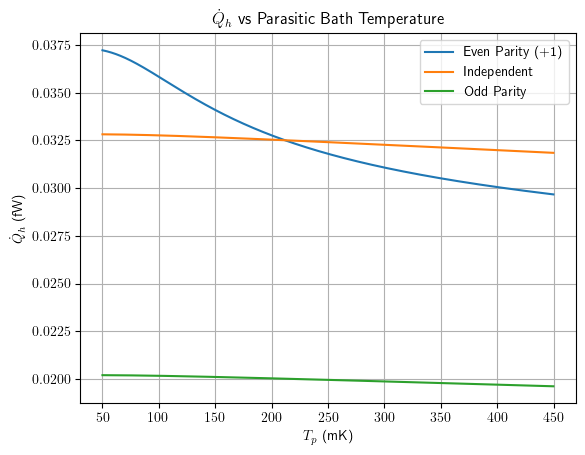

In [14]:
T_parT = (T_par*5.6*10**9*6.626*10**(-34))/(1.38*10**(-23))
plt.plot(T_parT*1e3, Q_coll_sup_2, label = 'Even Parity (+1)')
plt.plot(T_parT*1e3, Q_ind_2, label = 'Independent')
plt.plot(T_parT*1e3, Q_coll_sub_2, label = 'Odd Parity')
plt.xlabel(r'$T_p$ (mK)')
plt.ylabel(r'$\dot{Q}_h$ (fW)')
plt.title(r'$\dot{Q}_h$ vs Parasitic Bath Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
N3 = 1000
gamma_p_2 = 0.001 #0.001   # Parasitic relaxation
gamma_deph_3  = np.linspace(0.0001, 0.01, N3)  # Pure dephasing (σ_z)

# Temperatures  (ℏ = k_B = 1)
T_local = 0.186    # Parasitic bath
T_h     = 1.2087    # Hot bath
T_c     = 0.186   # Cold bath


#w_vals = np.linspace(0.5, 1.5, N)
#W1, W2 = np.meshgrid(w_vals, w_vals)

Q_ind_3   = np.zeros(N3)   # independent current
Q_coll_sup_3  = np.zeros(N3)  # collective current
Q_coll_sub_3  = np.zeros(N3) 
Ratio_sup_3   = np.zeros(N3)   # enhancement factor
Ratio_sub_3   = np.zeros(N3)   # enhancement factor


for k, gamma_d in enumerate(gamma_deph_3):

    # Independent-bath steady state and current
    rho_ind = QH.rho_ss_termic_indepentend(
        1, 1,
        gamma_p_2, T_local, gamma_d,
        T_h, gamma_h, T_c, gamma_c,
        w0, Qf
    )
    Q_ind_3[k] = QH.Current_ind(1, 1, rho_ind, T_h, gamma_h, w0, Qf)

    # Collective-bath steady state and current
    rho_coll_sup = QH.rho_ss_termic_collective_sup(
        1, 1,
        gamma_p_2, T_local, gamma_d,
        T_h, gamma_h, T_c, gamma_c,
        w0, Qf
    )
    Q_coll_sup_3[k] = QH.Current_coll(1, 1, rho_coll_sup, T_h, gamma_h, w0, Qf, Jm_h, Jp_h)


    Ratio_sup_3[k]  = Q_coll_sup_3[k] / Q_ind_3[k]
    
    rho_coll_sub = QH.rho_ss_termic_collective_sub(
        1, 1,
        gamma_p_2, T_local, gamma_d,
        T_h, gamma_h, T_c, gamma_c,
        w0, Qf
    )
    Q_coll_sub_3[k] = QH.Current_coll(1, 1, rho_coll_sub, T_h, gamma_h, w0, Qf, Jm_h, Jp_h)


    Ratio_sub_3[k]  = Q_coll_sub_3[k] / Q_ind_3[k]
    
    


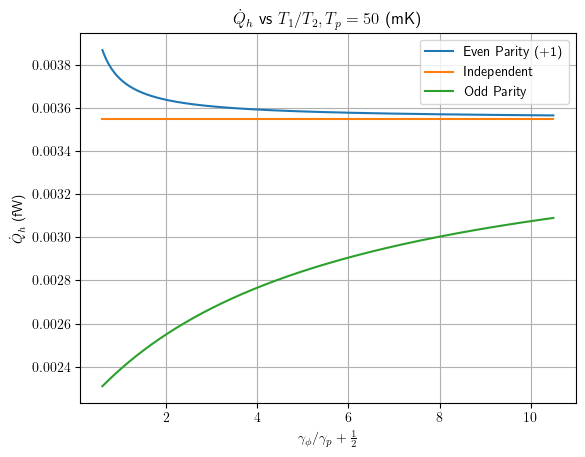

In [16]:
plt.plot(gamma_deph_3/gamma_p_2 + 0.5, Q_coll_sup_3, label = 'Even Parity (+1)')
plt.plot(gamma_deph_3/gamma_p_2 + 0.5, Q_ind_3, label = 'Independent')
plt.plot(gamma_deph_3/gamma_p_2 + 0.5, Q_coll_sub_3, label = 'Odd Parity')
plt.xlabel(r'$\gamma_{\phi}/\gamma_p + \frac{1}{2}$')
plt.ylabel(r'$\dot{Q}_h$ (fW)')
plt.title(r'$\dot{Q}_h$ vs $T_1/T_2, T_p = 50$ (mK)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
N4 = 1000
Qf_3 = 7.1798
gamma_p_3 = 0.001 #0.0025 #0.001   # Parasitic relaxation
gamma_deph_4  = 0

# Temperatures  (ℏ = k_B = 1)
T_local = 0.186 #0.26    # Parasitic bath
T_h     = 1.2087 #2   # Hot bath
T_c     = 0.186 #0.25   
gamma_h_3 = np.linspace(0.001, 0.1, N4)
gamma_c_3 = gamma_h_3


#w_vals = np.linspace(0.5, 1.5, N)
#W1, W2 = np.meshgrid(w_vals, w_vals)

Q_ind_4   = np.zeros(N4)   # independent current
Q_coll_sup_4  = np.zeros(N4)  # collective current
Q_coll_sub_4  = np.zeros(N4) 
Ratio_sup_4   = np.zeros(N4)   # enhancement factor
Ratio_sub_4   = np.zeros(N4)   # enhancement factor


for k, gh in enumerate(gamma_h_3):

    # Independent-bath steady state and current
    rho_ind = QH.rho_ss_termic_indepentend(
        1, 1,
        gamma_p_3, T_local, gamma_deph_4,
        T_h, gh, T_c, gamma_c_3[k],
        w0, Qf_3
    )
    Q_ind_4[k] = QH.Current_ind(1, 1, rho_ind, T_h, gh, w0, Qf_3)

    # Collective-bath steady state and current
    rho_coll_sup = QH.rho_ss_termic_collective_sup(
        1, 1,
        gamma_p_3, T_local, gamma_deph_4,
        T_h, gh, T_c, gamma_c_3[k],
        w0, Qf_3
    )
    Q_coll_sup_4[k] = QH.Current_coll(1, 1, rho_coll_sup, T_h, gh, w0, Qf_3, Jm_h, Jp_h)


    Ratio_sup_4[k]  = Q_coll_sup_4[k] / Q_ind_4[k]
    
    rho_coll_sub = QH.rho_ss_termic_collective_sub(
        1, 1,
        gamma_p_3, T_local, gamma_deph_4,
        T_h, gh, T_c, gamma_c_3[k],
        w0, Qf_3
    )
    Q_coll_sub_4[k] = QH.Current_coll(1, 1, rho_coll_sub, T_h, gh, w0, Qf_3, Jm_h, Jp_h)


    Ratio_sub_4[k]  = Q_coll_sub_4[k] / Q_ind_4[k]
    

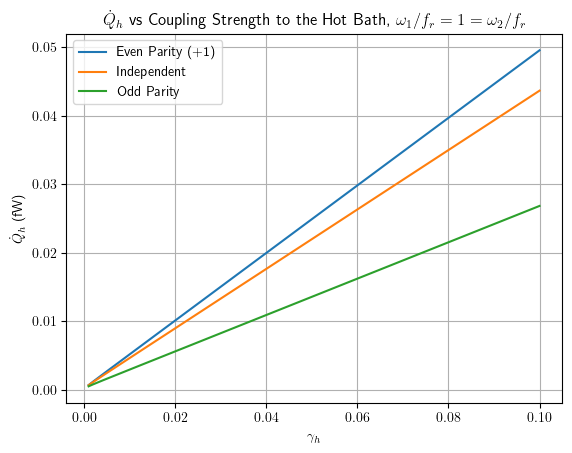

In [18]:
plt.plot(gamma_h_3, Q_coll_sup_4, label = 'Even Parity (+1)')
plt.plot(gamma_h_3, Q_ind_4, label = 'Independent')
plt.plot(gamma_h_3, Q_coll_sub_4, label = 'Odd Parity')
plt.xlabel(r'$\gamma_{h}$')
plt.ylabel(r'$\dot{Q}_h$ (fW)')
plt.title(r'$\dot{Q}_h$ vs Coupling Strength to the Hot Bath, $\omega_1/f_r = 1 = \omega_2/f_r$')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
N5 = 1000

T_h_3     = np.linspace(0.372, 1.2087, N5) #np.linspace(0.5, 2, N5)   # Hot bath 
gamma_h_4 = 0.0075 #0.125
gamma_c_4 = gamma_h_4


#w_vals = np.linspace(0.5, 1.5, N)
#W1, W2 = np.meshgrid(w_vals, w_vals)

Q_ind_5   = np.zeros(N5)   # independent current
Q_coll_sup_5  = np.zeros(N5)  # collective current
Q_coll_sub_5  = np.zeros(N5) 
Ratio_sup_5  = np.zeros(N5)   # enhancement factor
Ratio_sub_5   = np.zeros(N5)   # enhancement factor


for k, Th in enumerate(T_h_3):

    # Independent-bath steady state and current
    rho_ind = QH.rho_ss_termic_indepentend(
        1, 1,
        gamma_p_3, T_local, gamma_deph_4,
        Th, gamma_h_4, T_c, gamma_c_4,
        w0, Qf_3
    )
    Q_ind_5[k] = QH.Current_ind(1, 1, rho_ind, Th, gamma_h_4, w0, Qf_3)

    # Collective-bath steady state and current
    rho_coll_sup = QH.rho_ss_termic_collective_sup(
        1, 1,
        gamma_p_3, T_local, gamma_deph_4,
        Th, gamma_h_4, T_c, gamma_c_4,
        w0, Qf_3
    )
    Q_coll_sup_5[k] = QH.Current_coll(1, 1, rho_coll_sup, Th, gamma_h_4, w0, Qf_3, Jm_h, Jp_h)


    Ratio_sup_5[k]  = Q_coll_sup_5[k] / Q_ind_5[k]
    
    rho_coll_sub = QH.rho_ss_termic_collective_sub(
        1, 1,
        gamma_p_3, T_local, gamma_deph_4,
        Th, gamma_h_4, T_c, gamma_c_4,
        w0, Qf_3
    )
    Q_coll_sub_5[k] = QH.Current_coll(1, 1, rho_coll_sub, Th, gamma_h_4, w0, Qf_3, Jm_h, Jp_h)


    Ratio_sub_5[k]  = Q_coll_sub_5[k] / Q_ind_5[k]

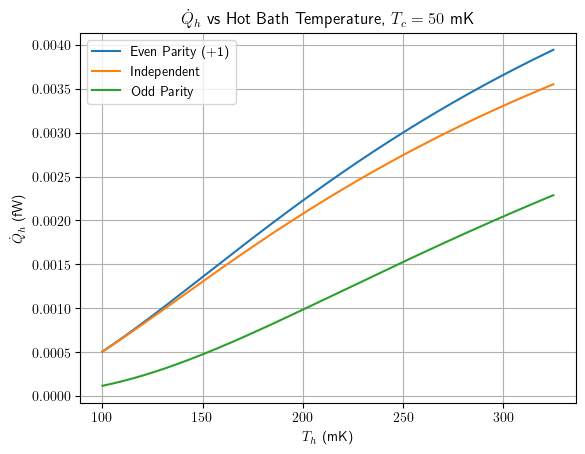

In [20]:
T = (T_h_3*5.6*10**9*6.626*10**-34)/(1.38*10**-23)
plt.plot(T*1e3, Q_coll_sup_5, label = 'Even Parity (+1)')
plt.plot(T*1e3, Q_ind_5, label = 'Independent')
plt.plot(T*1e3, Q_coll_sub_5, label = 'Odd Parity')
plt.xlabel(r'$T_{h}$ (mK)')
plt.ylabel(r'$\dot{Q}_h$ (fW)')
plt.title(r'$\dot{Q}_h$ vs Hot Bath Temperature, $T_c = 50$ mK')
plt.legend()
plt.grid(True)
plt.show()

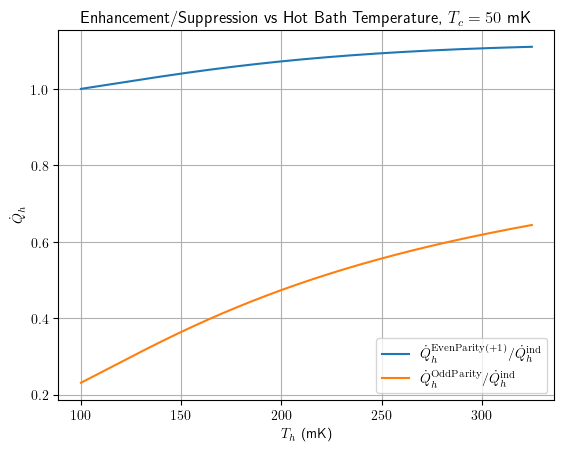

In [21]:
plt.plot(T*1e3, Ratio_sup_5, label = r'$\dot{Q}_h^{\rm Even Parity (+1)}/\dot{Q}_h^{\rm ind}$')
plt.plot(T*1e3, Ratio_sub_5, label = r'$\dot{Q}_h^{\rm Odd Parity}/\dot{Q}_h^{\rm ind}$')
plt.xlabel(r'$T_{h}$ (mK)')
plt.ylabel(r'$\dot{Q}_h$')
plt.legend()
plt.title(r'Enhancement/Suppression vs Hot Bath Temperature, $T_c = 50$ mK')
plt.grid(True)
plt.show()

In [22]:
N6 = 101
N7 = 10
   
gamma_h_4 = np.linspace(0.001, 0.1, N7)#[0.0075, 0.0075*2, 0.0075*5, 0.0075*10]

w_vals_2 = np.linspace(0.5, 1.5, 101)

gamma_c_4 = gamma_h_4


#w_vals = np.linspace(0.5, 1.5, N)
#W1, W2 = np.meshgrid(w_vals, w_vals)

Q_ind_6   = np.zeros((N6, N7))   # independent current
Q_coll_sup_6  = np.zeros((N6, N7))   # collective current
Q_coll_sub_6  = np.zeros((N6, N7)) 
Ratio_sup_6   = np.zeros((N6, N7))    # enhancement factor
Ratio_sub_6   = np.zeros((N6, N7))    # enhancement factor


for i, w1 in enumerate(w_vals_2):
    for j, gh in enumerate(gamma_h_4):

        # Independent-bath steady state and current
        rho_ind = QH.rho_ss_termic_indepentend(
            w1, 1,
            gamma_p_3, T_local, gamma_deph_4,
            T_h, gh, T_c, gamma_c_4[j],
            w0, Qf_3
        )
        Q_ind_6[i, j] = QH.Current_ind(w1, 1, rho_ind, T_h, gh, w0, Qf_3)

        # Collective-bath steady state and current
        rho_coll_sup = QH.rho_ss_termic_collective_sup(
            w1, 1,
            gamma_p_3, T_local, gamma_deph_4,
            T_h, gh, T_c, gamma_c_4[j],
            w0, Qf_3
        )
        Q_coll_sup_6[i, j] = QH.Current_coll(w1, 1, rho_coll_sup, T_h, gh, w0, Qf_3, Jm_h, Jp_h)


        Ratio_sup_6[i, j]  = Q_coll_sup_6[i, j] / Q_ind_6[i, j]

        rho_coll_sub = QH.rho_ss_termic_collective_sub(
            w1, 1,
            gamma_p_3, T_local, gamma_deph_4,
            T_h, gh, T_c, gamma_c_4[j],
            w0, Qf_3
        )
        Q_coll_sub_6[i, j] = QH.Current_coll(w1, 1, rho_coll_sub, T_h, gh, w0, Qf_3, Jm_h, Jp_h)


        Ratio_sub_6[i, j]  = Q_coll_sub_6[i, j] / Q_ind_6[i, j]

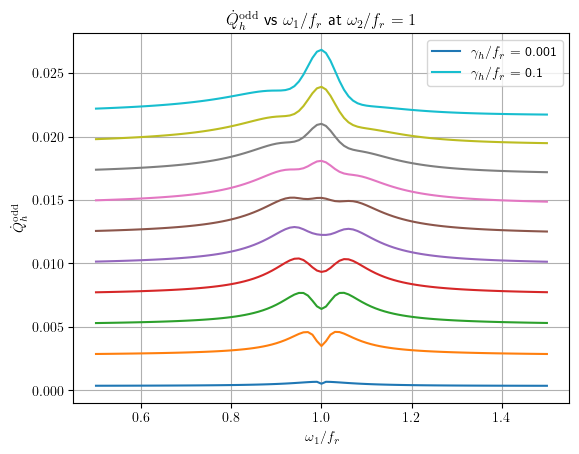

In [23]:
for i, gh in enumerate(gamma_h_4):
    if i == 0 or i == 9:
        plt.plot(w_vals, Q_coll_sub_6[:, i], label=f"$\gamma_h/f_r$ = {gh}")
    else:
        plt.plot(w_vals, Q_coll_sub_6[:, i])

plt.xlabel(r'$\omega_1/f_r$')
plt.ylabel(r'$\dot{Q}_h^{\rm odd}$')
plt.title(r'$\dot{Q}_h^{\rm odd}$ vs $\omega_1/f_r$ at $\omega_2/f_r = 1$')
plt.legend()
plt.grid(True)
plt.show()